# Task 7: Stock Market Prediction using Numerical and Textual Analysis

## *by Debopriya Bose*

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import yfinance as yf
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
import altair as alt
import tensorflow as tf
from tensorflow import keras
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

## Sentiment analysis of the textual data

In [6]:
#loading the dataset and displaying first 5 rows of the dataset
data_news = pd.read_csv('C:/Users/debop/OneDrive/Desktop/india-news-headlines.csv')
data_news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [10]:
#converting the publish date data type to date time
data_news["Date"] = pd.to_datetime(data_news["publish_date"], format = '%Y%m%d')
data_news.drop('publish_date', axis = 1, inplace = True)

In [11]:
data_news.head()

,headline_category,headline_text,Date
0,unknown,Status quo will not be disturbed at Ayodhya; s...,2001-01-02
1,unknown,Fissures in Hurriyat over Pak visit,2001-01-02
2,unknown,America's unwanted heading for India?,2001-01-02
3,unknown,For bigwigs; it is destination Goa,2001-01-02
4,unknown,Extra buses to clear tourist traffic,2001-01-02


In [12]:
#displays the dimensions of the dataset
data_news.shape

(3650970, 3)

In [13]:
data_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   headline_category  object        
 1   headline_text      object        
 2   Date               datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 83.6+ MB


In [14]:
#checking all the values count (unique values total count)
data_news['headline_category'].value_counts()

india                                                    297491
unknown                                                  209583
city.mumbai                                              150451
city.delhi                                               137648
business.india-business                                  121195
                                                          ...  
nepal-india-earthquake.opinion                                8
elections.lok-sabha-elections-2019.tripura.news               8
best-products.home-decor-and-garden.living-room-decor         8
profiles.india-profiles                                       8
pms-us-visit                                                  8
Name: headline_category, Length: 1041, dtype: int64

In [15]:
#total unique values count
data_news['headline_category'].value_counts().count()

1041

In [16]:
#checking all the values count (unique values total count)
data_news['headline_text'].value_counts()

Straight Answers                                                                                                          6723
Cartoons                                                                                                                  1536
Straight answers                                                                                                          1500
Photogallery                                                                                                              1353
Your say                                                                                                                  1012
                                                                                                                          ... 
Pak President Asif Ali Zardari at 7RCR; meets Manmohan Singh                                                                 1
Why Goa Inc is so happy with CM Manohar Parrikar                                                               

In [17]:
#total unique values count
data_news['headline_text'].value_counts().count()

3387380

In [18]:
#finding if any duplicate values are present
data_news.duplicated().sum()

24860

In [19]:
#sorting the dataset to delete the duplicates, to make duplicates come together one after another. The sorted dataset index values are also changed
cols = list(data_news.columns)
data_news.sort_values(by=cols, inplace=True, ignore_index=True)

In [20]:
#dropping the duplicates only keeping the last value (ordinally last row from sorted) of each duplicates
data_news.drop_duplicates(keep='last', inplace=True, ignore_index=True)

In [21]:
data_news.duplicated().sum()

0

In [22]:
#getting a list of unique dates in publish_date column
lst = data_news['Date'].value_counts().index.tolist()

In [23]:
#concatenating all the headline_text column values of same date in publish_date column
new = []
for x in lst:
  df = data_news.loc[data_news['Date'] == x]
  headlinetext = ''
  publishdate = str(x)
  headlinetext = df['headline_text'].iloc[0]
  for i in range(1 , len(df)):
    headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
  new.append(headlinetext)

In [24]:
#creating a new dataset
newsdf = pd.DataFrame({'Date': lst, 'headline_text' : new})

#sorting the dataset based on dates
newsdf.sort_values(by='Date', inplace = True, ignore_index=True)
newsdf

,Date,headline_text
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...
4,2001-01-06,Anti-immigration think-tank berates Clinton re...
...,...,...
7712,2022-03-27,F1 2022: Sergio Perez grabs pole position at S...
7713,2022-03-28,Adani Total forays into electric mobility infr...
7714,2022-03-29,'ONGC sells Russia's Sokol oil to Indian refin...
7715,2022-03-30,8 days; 7 hikes: Petrol crosses Rs 100/L mark....


In [25]:
#fucntions to obtain polarity and subjectivity from the text
def polarity(text):
  pol_val = TextBlob(text).sentiment.polarity
  return pol_val
def subjectivity(text):
  sub_val = TextBlob(text).sentiment.subjectivity
  return sub_val

In [27]:
newsdf['polarity'] = newsdf['headline_text'].apply(polarity)
newsdf['subjectivity'] = newsdf['headline_text'].apply(subjectivity)

In [28]:
newsdf

,Date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935
...,...,...,...,...
7712,2022-03-27,F1 2022: Sergio Perez grabs pole position at S...,0.026188,0.371042
7713,2022-03-28,Adani Total forays into electric mobility infr...,0.055232,0.389939
7714,2022-03-29,'ONGC sells Russia's Sokol oil to Indian refin...,0.095037,0.404044
7715,2022-03-30,8 days; 7 hikes: Petrol crosses Rs 100/L mark....,0.037729,0.350965


In [30]:
#selecting required columns
newsdf = newsdf.filter(['Date', 'polarity', 'subjectivity'], axis=1)

In [31]:
newsdf.head()

,Date,polarity,subjectivity
0,2001-01-02,0.193519,0.293056
1,2001-01-03,0.088462,0.407692
2,2001-01-04,0.091426,0.481895
3,2001-01-05,0.257415,0.465542
4,2001-01-06,0.219481,0.464935


In [32]:
newsdf['Date'].duplicated().sum()

0

## Numerical analysis of historical stock prices

In [108]:
#collecting data from yahoo finance
bse_data = yf.download('^BSESN', start='2015-01-01', end='2020-06-30')

[*********************100%***********************]  1 of 1 completed


In [109]:
bse_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [110]:
bse_data.reset_index(inplace=True)

In [111]:
bse_data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [112]:
def stock_weekmovingavg(wks, df):
  dateclose_data = pd.DataFrame({'Date': df['Date'], 'Close':df['Close']})
  dateclose_data.set_index('Date', inplace=True)
  num = wks * 5                                 #calculating the number of days in the week. 5 days because BSE is open for 5 days / week
  dateclose_data['movingavg'] = dateclose_data['Close'].rolling(window=num).mean().shift()
  return dateclose_data.dropna()

In [113]:
stock_weekmovingavg(4, bse_data).head()

,Close,movingavg
Date,,
2015-02-02,29122.269531,28256.509570
2015-02-03,29000.140625,28318.228027
2015-02-04,28883.109375,28376.119043
2015-02-05,28850.970703,28470.901465
2015-02-06,28717.910156,28568.008984


<AxesSubplot:xlabel='Date'>

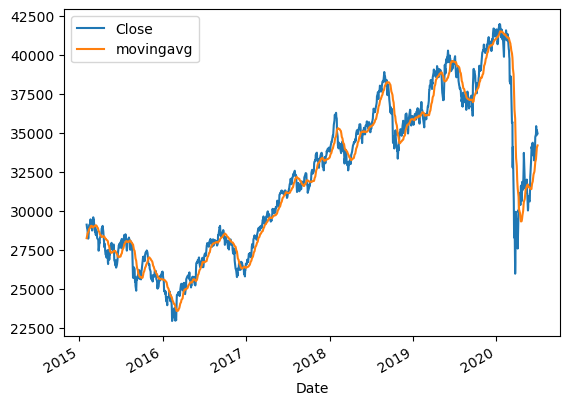

In [114]:
stock_weekmovingavg(4, bse_data).plot()

In [115]:
altdata_fourweek = stock_weekmovingavg(4, bse_data)
altdata_fourweek.reset_index(inplace=True)
altdata_fourweek.rename(columns={list(altdata_fourweek)[0]:'date'}, inplace=True)

In [116]:
alt.Chart(altdata_fourweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

C:\Users\debop\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


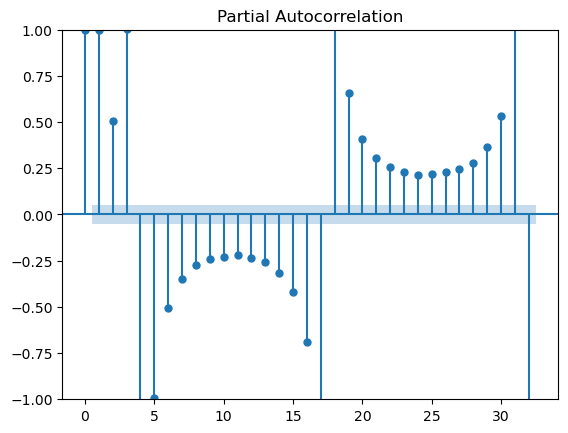

In [117]:
plotfourweek = altdata_fourweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfourweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fourweek['date']))) 
del plotfourweek['date']
sm.graphics.tsa.plot_pacf(plotfourweek.values.squeeze())
plt.show()

In [118]:
stock_weekmovingavg(16, bse_data).head()

,Close,movingavg
Date,,
2015-05-05,27440.140625,28447.880933
2015-05-06,26717.369141,28442.283936
2015-05-07,26599.109375,28428.222046
2015-05-08,27105.390625,28423.367651
2015-05-11,27507.300781,28425.824780


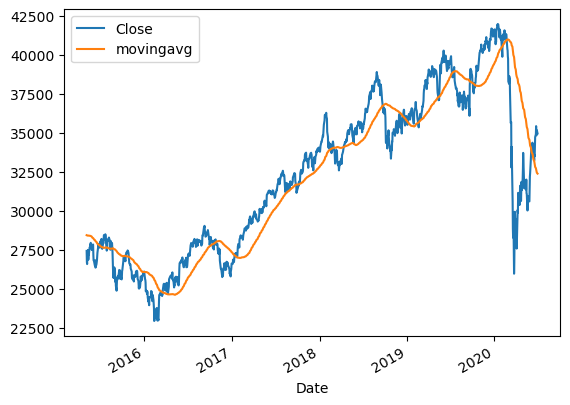

In [119]:
stock_weekmovingavg(16, bse_data).plot()
plt.show()

In [120]:
altdata_sixteenweek = stock_weekmovingavg(16, bse_data)
altdata_sixteenweek.reset_index(inplace=True)
altdata_sixteenweek.rename(columns={list(altdata_sixteenweek)[0]:'date'}, inplace=True)
alt.Chart(altdata_sixteenweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

In [121]:
bse_data['Date'].duplicated().sum()

0

In [122]:
#Adding the 'polarity' and 'subjectivity' columns obtained from the textual dataset to the numerical dataset with respect to 'Date'
bse_data = pd.merge(bse_data, newsdf, how='left', on=['Date'])

In [123]:
bse_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,0.055586,0.455251
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,0.100081,0.433132
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,0.055802,0.386579
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,0.034707,0.386916
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,0.060173,0.408416


In [124]:
bse_data.isnull().sum().sum()

0

In [125]:
bse_data.loc[len(bse_data)] = ['2020-06-30', bse_data['Open'].mean(), bse_data['High'].mean(), bse_data['Low'].mean(),
                       bse_data['Close'].mean(), bse_data['Adj Close'].mean(), bse_data['Volume'].median(), newsdf['polarity'].mean(), newsdf['subjectivity'].mean() ]

In [126]:
def boolean_shock(percent, df, col):
  data = df.filter(['Date', col], axis=1) #df.copy()
  data.set_index('Date', inplace=True)
  data['percentchg'] = (data[col].pct_change()) * 100  #percentage change compare to previous volume using pct_change() function
  data['shock'] = data['percentchg'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(col, axis = 1, inplace = True)
  return data.dropna()

In [127]:
def priceboolean_shock(percent, df):
  df['Date'] = pd.to_datetime(df['Date'])
  data = df.filter(['Date', 'High', 'Low','Close'], axis=1) #df.copy()
  data.set_index('Date', inplace=True)
  data['priceavg'] = (data['High'] + data['Low'] + data['Close']) / 3
  data['shock'] = (data['priceavg'].pct_change()) * 100
  data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(['High', 'Low', 'Close'], axis = 1, inplace = True)
  return data

In [128]:
def reverseboolean_shock(percent, df, col):
  data = df.filter(['Date', col], axis=1) #df.copy()
  data.set_index('Date', inplace=True)
  data = data.reindex(index=data.index[::-1])
  data['percentchg'] = (data[col].pct_change()) * 100
  data['shock'] = data['percentchg'].apply(lambda x: 1 if x > percent else 0)
  data.drop(col, axis = 1, inplace = True)
  data = data.reindex(index=data.index[::-1])
  return data.dropna()

In [129]:
def pricereverseboolean_shock(percent, df):
  data = df.filter(['Date', 'High', 'Low','Close'], axis=1) #df.copy()
  data.set_index('Date', inplace=True)
  data = data.reindex(index=data.index[::-1])
  data['reversepriceavg'] = (data['High'] + data['Low'] + data['Close']) / 3
  data['shock'] = (data['reversepriceavg'].pct_change()) * 100
  data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(['High', 'Low', 'Close'], axis = 1, inplace = True)
  data = data.reindex(index=data.index[::-1])
  return data.dropna()

In [130]:
bse_data.dtypes

Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume          float64
polarity        float64
subjectivity    float64
dtype: object

In [131]:

bse_data["Date"] = pd.to_datetime(bse_data["Date"])

In [132]:
bse_data.dtypes

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Adj Close              float64
Volume                 float64
polarity               float64
subjectivity           float64
dtype: object

In [133]:
bse_data["month"] = bse_data['Date'].dt.month
bse_data["day"] = bse_data['Date'].dt.day
bse_data["dayofweek"] = bse_data['Date'].dt.dayofweek
bse_data["week"] = bse_data['Date'].dt.week
bse_data['movingavg4weeks'] = round(bse_data['Close'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
bse_data['movingavg16weeks'] = round(bse_data['Close'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
bse_data['movingavg28weeks'] = round(bse_data['Close'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 16 weeks
bse_data['movingavg40weeks'] = round(bse_data['Close'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 28 weeks
bse_data['movingavg52weeks'] = round(bse_data['Close'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  #add 12 weeks to 40 weeks
bse_data['window10days'] = round(bse_data['Close'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
bse_data['window50days'] = round(bse_data['Close'].rolling(window = 50, min_periods = 1).mean().shift(),2)
bse_data['volumeshock'] = round(boolean_shock(10, bse_data, 'Volume').reset_index()['shock'], 2)
bse_data['closeshock2'] = round(reverseboolean_shock(2, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['closeshock5'] = round(reverseboolean_shock(5, bse_data, 'Close').reset_index()['shock'],2)
bse_data['closeshock10'] = round(reverseboolean_shock(10, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['priceshock'] = round(priceboolean_shock(10, bse_data).reset_index()['shock'], 2)
bse_data['reversebooleanshock2'] = round(reverseboolean_shock(2, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['reversebooleanshock5'] = round(reverseboolean_shock(5, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['pricereverseshock2'] = round(pricereverseboolean_shock(2, bse_data).reset_index()['shock'], 2)
bse_data['polarity'] = round(bse_data['polarity'] , 2)
bse_data['subjectivity'] = round(bse_data['subjectivity'] , 2)
bse_data['price'] = round((bse_data['High'] + bse_data['Low'] + bse_data['Close']) / 3 , 2)
bse_data['Close'] = round(bse_data['Close'] , 2)

C:\Users\debop\AppData\Local\Temp\ipykernel_17880\1525052481.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  bse_data["week"] = bse_data['Date'].dt.week


In [135]:
bse_data.isnull().sum().sum()

13

In [136]:
#fillinf the null columns
bse_data.fillna(method = 'bfill', inplace = True)

In [137]:
bse_data.isnull().sum().sum()

6

In [138]:
#fillinf the null columns
bse_data.fillna(method = 'ffill', inplace = True)

In [139]:
bse_data.isnull().sum().sum()

0

## Building a hybrid predictive model for predicting the 'close' price

In [163]:
X = bse_data.drop(['Close'], axis = 1)
y = bse_data[['Close']]
data_y = y.values

In [164]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_y)

scaled_data

array([[0.25978222],
       [0.25738337],
       [0.21239264],
       ...,
       [0.64310134],
       [0.63206233],
       [0.47536998]])

In [165]:
bse_data.dtypes

Date                    datetime64[ns]
Open                           float64
High                           float64
Low                            float64
Close                          float64
Adj Close                      float64
Volume                         float64
polarity                       float64
subjectivity                   float64
month                            int64
day                              int64
dayofweek                        int64
week                             int64
movingavg4weeks                float64
movingavg16weeks               float64
movingavg28weeks               float64
movingavg40weeks               float64
movingavg52weeks               float64
window10days                   float64
window50days                   float64
volumeshock                    float64
closeshock2                    float64
closeshock5                    float64
closeshock10                   float64
priceshock                       int64
reversebooleanshock2     

In [166]:
training_data_len = int(np.ceil( len(data_y) * .95 ))


#creating the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

#splitting the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
#converting the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.25978222, 0.25738337, 0.21239264, 0.20825386, 0.22751042,
       0.23717686, 0.243855  , 0.23545851, 0.23130552, 0.26965812,
       0.27209696, 0.27947139, 0.30697865, 0.31246211, 0.31862816,
       0.33298651, 0.34836481, 0.34774062, 0.35419246, 0.32793988,
       0.32474633, 0.3183187 , 0.31215949, 0.31046798, 0.30346512,
       0.27764936, 0.28439803, 0.29378447, 0.30805387, 0.32330744,
       0.32546261, 0.33516641, 0.34264031, 0.3304903 , 0.31700139,
       0.31855659, 0.31873184, 0.30497769, 0.32989611, 0.34247558,
       0.34955897, 0.33834891, 0.34193929, 0.3101422 , 0.30304198,
       0.30037367, 0.31464886, 0.29217033, 0.28871837, 0.30443718,
       0.29842375, 0.2904004 , 0.27942245, 0.27578786, 0.27419319,
       0.27156751, 0.23713475, 0.23719054, 0.2644115 , 0.2634447 ])]
[0.2793729737695254]

[array([0.25978222, 0.25738337, 0.21239264, 0.20825386, 0.22751042,
       0.23717686, 0.243855  , 0.23545851, 0.23130552, 0.26965812,
       0.27209696, 0.27947139, 0.306

In [167]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#building the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

#training the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1219/1219 [==============================] - 48s 34ms/step - loss: 0.0033


In [168]:
#creating the testing data set
#creating a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]

#creating the data sets x_test and y_test
x_test = []
y_test = data_y[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
#converting the data to a numpy array
x_test = np.array(x_test)

#reshaping the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#obtaining the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#obtaining the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3/3 [==============================] - 1s 20ms/step


1228.2734896013421

C:\Users\debop\AppData\Local\Temp\ipykernel_17880\3628658671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


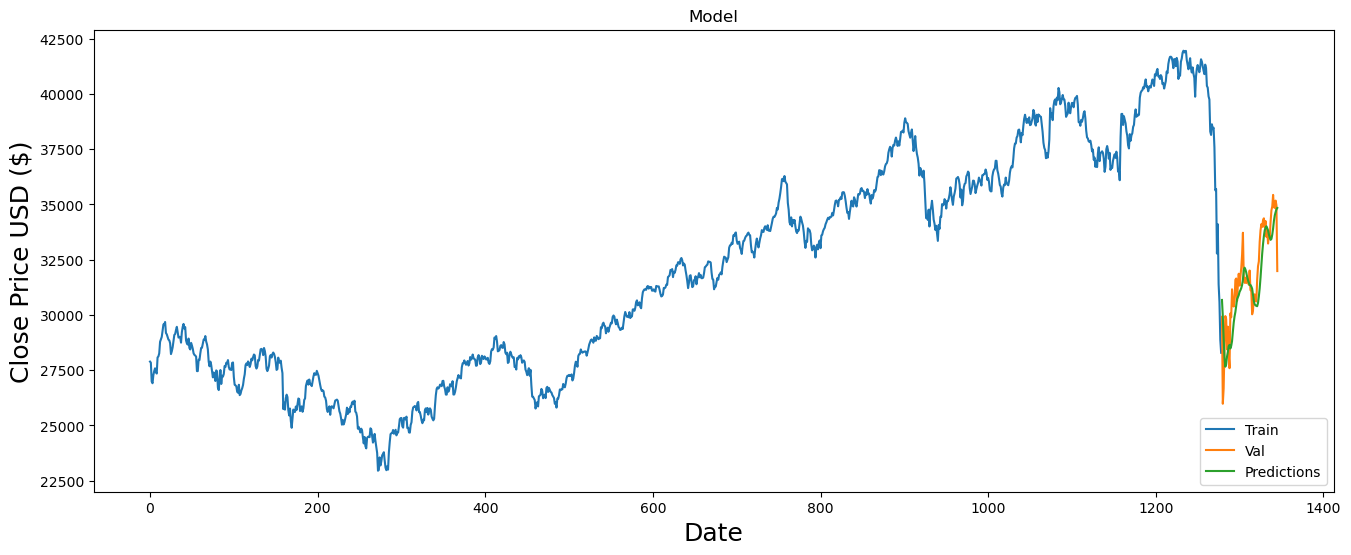

In [169]:
#plotting the data
train = y[:training_data_len]
valid = y[training_data_len:]
valid['Predictions'] = predictions

#visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Conclusion: As we all know, it is really difficult to make stock market predictions, so here I have tried to build a hybrid predictive model based on numerical and textual datasets and I have obtained somewhat satisfactory results.